In [1]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from PIL import Image
from tqdm import tqdm
from torchvision.datasets import ImageFolder

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# Define the root directory where your data is stored
root_folder = r"C:\Users\emanu\Downloads\archive\Car-Bike-Dataset"

In [4]:
# Load the dataset using ImageFolder
dataset = ImageFolder(root_folder)

In [5]:
# Check the class to index mapping
print(dataset.class_to_idx)

{'Bike': 0, 'Car': 1}


In [9]:
# Create ResNet50 model for feature extraction
cnn_model = timm.create_model("resnet50", pretrained=True, features_only=True)
cnn_model = cnn_model.eval().cuda()

In [10]:
# Define the transformation
transform = create_transform(**resolve_data_config(cnn_model.pretrained_cfg))

In [11]:
# Function to extract features
def extract_features_resnet(model, transform, image):
    x = transform(image).unsqueeze(0).cuda()
    out = model(x)
    return out[4].mean([2, 3]).detach().cpu().reshape(-1)

In [12]:
# Extract features and labels
x_data = []
y_data = []
for image_path, label in tqdm(dataset.imgs):
    image = Image.open(image_path).convert('RGB')
    features = extract_features_resnet(cnn_model, transform, image)
    x_data.append(features.numpy())
    y_data.append(label)

  8%|██████▎                                                                        | 313/3941 [00:07<01:17, 46.86it/s]C:\Users\emanu\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 3941/3941 [01:26<00:00, 45.58it/s]


In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Convert lists to numpy arrays
x_data_np = np.array(x_data)
y_data_np = np.array(y_data)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data_np, y_data_np, test_size=0.2, random_state=42)

# Train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)

# Predict on the test set
y_pred = logreg.predict(x_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9961977186311787
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       399
           1       0.99      1.00      1.00       390

    accuracy                           1.00       789
   macro avg       1.00      1.00      1.00       789
weighted avg       1.00      1.00      1.00       789



In [16]:
from fastai.vision.all import *
import pandas as pd
from torchvision.models import resnet50
import splitfolders
import os

In [27]:
input_folder = r"C:\Users\emanu\Downloads\archive\Car-Bike-Dataset"
output = r"C:\Users\emanu\Downloads\archive\Car-Bike-Dataset\test_data"

In [28]:
# Create the output directory if it doesn't exist
os.makedirs(output, exist_ok=True)

In [29]:
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1))

Copying files: 3941 files [00:07, 525.24 files/s]


In [30]:
# Define path to training data
path = Path('C:/Users/emanu/Downloads/archive/Car-Bike-Dataset/test_data/train')

In [31]:
# Define resizing and you normalize pixels. In this part you can use squish method, crop, or pad
item_tfms = Resize(460, method='crop')
batch_tfms = [*aug_transforms(size=224, min_scale=0.75),
              Normalize.from_stats(*imagenet_stats)]

In [32]:
# The DataBlock
datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items=get_image_files,
                      splitter=RandomSplitter(valid_pct=0.2, seed=42),
                      get_y=parent_label,
                      item_tfms=item_tfms,
                      batch_tfms=batch_tfms)

In [33]:
# The DataLoader with the batch size you want to use
dls = datablock.dataloaders(path, bs=64)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\emanu/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:03<00:00, 26.0MB/s]


C:\Users\emanu\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


SuggestedLRs(valley=0.0012022644514217973)

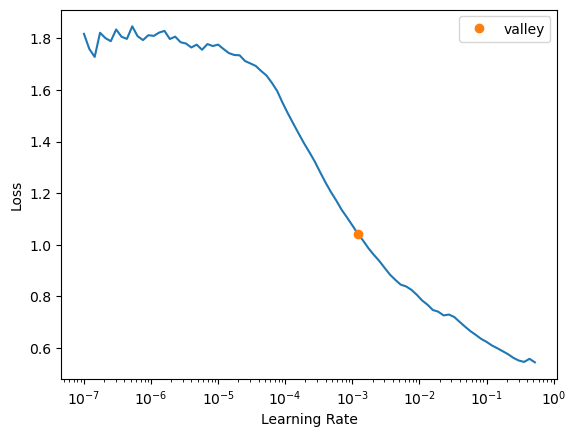

In [34]:
# Call the model. In this option you can choose any cnn model like resnet18, alexnet, vgg_11, etc.
learn = vision_learner(dls, resnet50, metrics=RocAucBinary())

# Find the optimal learning rate.
learn.lr_find()

In [35]:
# Copy the learning rate that you get from previous chunk of code and define the number of epochs you want to try. The Learning Rate is located above the plot
learn.fit_one_cycle(100, 0.0012022644514217973)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.444042,0.064264,0.997188,04:33


KeyboardInterrupt: 